In [2]:
#Выполнить предобработку данных (продумать самостоятельно)

#Поделить на две выборки - валидационную и обучающую.

#Предложить 5 принципиально разных архитектур (количесвто слоёв, число нейронов, тип слоя, функция активации и т.д.)

#Каждую архитектуру обучить, визуализировать кривые обучения (для тестовой и валидационной выборок). Сравнить между собой.

#Написать утилиту, которая будет строить график предсказания будущих значений на основе начального фрагмента.

#Написать классификатор, который выдаёт рекомендации по конвертации актива.

#Adjust data (choose adjustment by yourself)

#Split into 2 datasets for validation and learning

#Suggest 5 different architectures (number of layers, number of neurons, layer types, activation function etc.)

#Create an util for graphic represetation of learning curves (for test and validation sets). Compare these graphs

#Create a classificator for active conversion recommendations

In [3]:
import matplotlib.pyplot as plt

Let's read the data set and plot it

In [4]:
data = eval(open('task1.txt', 'r').read())
data = [float(data[i]) for i in range(len(data))]

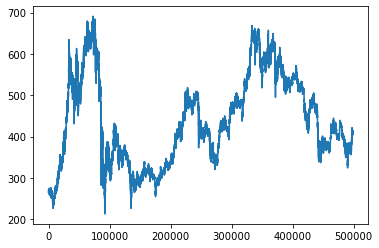

In [5]:
plt.plot(range(len(data)), data)
plt.show()

Let's propose several methods for data normalization

In [6]:
def noNorm(data):
    return [i for i in data]

def conventionalNorm(data):
    a, b = min(data), max(data)
    return [(x - (b - a) / 2) / (b - a) for x in data]

def rawChangeNorm(data):
    res = [0,]
    for i in [1 + j for j in range(len(data) - 1)]:
        res.append(data[i] - data[i-1])
    return res

def relativeChangeNorm(data):
    res = [0,]
    for i in [1 + j for j in range(len(data) - 1)]:
        res.append((data[i] - data[i-1]) / data[i-1])
    return res

print("no normalization:", noNorm(data[:20]))
print("conventional normalization:", conventionalNorm(data[:20]))
print("raw change normalization:", rawChangeNorm(data[:20]))
print("relative change normalization:", relativeChangeNorm(data[:20]))

no normalization: [264.3555, 264.3036, 264.2789, 264.3605, 264.3539, 264.2027, 264.2849, 264.2578, 264.0906, 264.0058, 264.1437, 264.1797, 264.2599, 264.3004, 264.382, 264.4754, 264.6475, 264.4376, 264.5201, 264.4135]
conventional normalization: [411.4611968209717, 411.3803179055906, 411.341826398656, 411.4689886239949, 411.4587034440042, 411.223079320582, 411.3511765622838, 411.3089449898979, 411.0483870968015, 410.9162381175277, 411.13113604490803, 411.1872370266753, 411.31221754716773, 411.37533115165576, 411.50249337699466, 411.64804425746837, 411.9162381175276, 411.58913822661293, 411.717702976496, 411.55158173604104]
raw change normalization: [0, -0.05189999999998918, -0.024699999999995725, 0.08159999999998035, -0.006599999999991724, -0.1512000000000171, 0.08220000000000027, -0.027100000000018554, -0.1671999999999798, -0.0847999999999729, 0.1379000000000019, 0.036000000000001364, 0.08019999999999072, 0.04050000000000864, 0.08159999999998035, 0.09339999999997417, 0.172100000000000

Let's define general customizable model to train

In [7]:
import torch.nn

class Linear(torch.nn.Module):
    def __init__(self, config):
        super(Linear, self).__init__()
        architecture = []
        for x in config:
            architecture.append(torch.nn.Linear(x["in"], x["out"]))
            architecture.append(x["act"])
        self.layers = torch.nn.Sequential(*architecture)
        
    def forward(self, x):
        x = x.flatten()
        return self.layers(x)

In [25]:
import numpy as np 
import time

def splitData(data, batchSize):
    xx = [data[i:i + 10] for i in range(len(data) - batchSize)]
    xx = np.array(xx, dtype=np.float)
    xx = torch.from_numpy(xx).float()
    
    yy = [data[i] for i in [10 + j for j in range(len(data) - batchSize)]]
    yy = np.array(yy, dtype=np.float)
    yy = torch.from_numpy(yy).float()
    
    return xx, yy

def batches(device, x, y, batchSize):
    start = time.time()
    dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    print("batch preparation finished in ", time.time() - start)
    for [xBatch, yBatch] in loader:
        yield xBatch, yBatch

In [41]:
import time

def train(model, xdata, ydata, batchSize, lossFunc, optimizer, device, nEpochs = 50):
    for e in range(nEpochs):
        start = time.time()
        cumLoss = 0
        n = 0
        avgIter = 0
        for x, y in batches(device, xdata, ydata, batchSize):
            pred = model(x)
            optimizer.zero_grad()
            loss = lossFunc(pred, y)
            cumLoss += loss.item()
            loss.backward()
            optimizer.step()
            n += 1
        avgLoss = cumLoss / n
        elapsed = time.time() - start
        print(f"Epoch {str(e + 1):>02} Avg train loss: {avgLoss:.4f} Elapsed time: {elapsed:.2f}s")

Lets try the first random architecture

In [ ]:
d = noNorm(data)
dTrain, dTest = d[:int(0.8 * len(d))], d[int(0.8 * len(d)):]

device = torch.device("cpu")

model = Linear([
    {"in": 10, "out": 5, "act": torch.nn.ReLU()},
    {"in": 5, "out": 3, "act": torch.nn.ReLU()},
    {"in": 3, "out": 1, "act": torch.nn.ReLU()}
]).to(device)
batchSize = 10
xx, yy = splitData(dTrain, 10)

learningRate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
lossFunc = torch.nn.L1Loss(reduction='sum')

train(model, xx, yy, 10, lossFunc, optimizer, device, nEpochs=10)

In [ ]:
xTest, yTest = splitData(dTest, 10)
